
# Incremental Structure-from-Motion (SfM) with OpenCV, NumPy, SciPy

This notebook walks through an incremental SfM pipeline to recover camera poses and a sparse 3D point cloud from 20 ordered images in `images/001.jpg`..`020.jpg`. Replace the intrinsic matrix `K` with values from your camera/EXIF before running. The code is written to be modular so you can swap feature types or tune thresholds.


In [ ]:
!pip install pyexiftool


In [ ]:
import os
import glob
from pathlib import Path
from exiftool import ExifTool
import json
import re

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

plt.rcParams["figure.figsize"] = (10, 7)

IMAGE_DIR = r"/content/Dataset"
IMAGE_PATTERN = "*.jpg"
IMAGE_COUNT = 20  # expected number of sequential frames

FEATURE_TYPE = "SIFT" if hasattr(cv2, "SIFT_create") else "ORB"
RATIO_TEST = 0.8
REPROJ_THRESHOLD_INIT = 4.0
REPROJ_THRESHOLD_PNP = 5.0 # Increased from 3.0 to 5.0 to allow more PnP inliers
MIN_PNP_POINTS = 5 # Reduced from 6 to 5 to allow processing for image 2

In [ ]:
!sudo apt-get install libimage-exiftool-perl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
Suggested packages:
  libposix-strptime-perl libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl libsombok3
  libunicode-linebreak-perl
0 upgraded, 5 newly installed, 0 to remove and 41 not upgraded.
Need to get 3,964 kB of archives.
After this operation, 23.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-zip-perl all 1.68-1 [90.2 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libimage-exiftool-perl all 12.40+dfsg-1 [3,717 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libmime-charset-perl all 1.012.2-1 [30.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/unive

In [ ]:
def extracting_EXIF(image_path):
    # Reading Metadata:
    with ExifTool() as et:
        output = et.execute("-j", image_path)
        meta = json.loads(output)[0]

    # Extracting Focal Length:
    focal_str = meta.get("EXIF:FocalLength") or meta.get("Composite:FocalLength")
    if focal_str is None:
        raise ValueError("FocalLength not found in EXIF")
    focal_mm = float(re.findall(r"[\d.]+", str(focal_str))[0])

    # Extracting Image Dimensions:
    width = meta.get("EXIF:ExifImageWidth") or meta.get("ImageWidth")
    height = meta.get("EXIF:ExifImageHeight") or meta.get("ImageHeight")

    if width is None or height is None:
        size = meta.get("Composite:ImageSize")
        size = size.replace("x", " ").replace("X", " ")
        width, height = map(int, size.split())
    width = int(width)
    height = int(height)

    return focal_mm, width, height


def computing_Intrinsic(width, height, focal_mm):
    # Known Sensor Sizes (from Internet):
    sensor_width_mm = 5.76
    sensor_height_mm = 4.29

    # Computing K:
    fx = focal_mm * (width / sensor_width_mm)
    fy = focal_mm * (height / sensor_height_mm)
    cx = width / 2
    cy = height / 2

    K = np.array([[fx, 0,  cx], [0,  fy, cy], [0,   0,  1]])
    print("\nK =\n", K)

    return K, fx, fy, cx, cy


image_path = r"/content/Dataset/1-Data.jpg"

focal_mm, width, height = extracting_EXIF(image_path)
K, fx, fy, cx, cy = computing_Intrinsic(width, height, focal_mm)


K =
 [[2.9750000e+03 0.0000000e+00 2.0160000e+03]
 [0.0000000e+00 2.9958042e+03 1.5120000e+03]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]



## Helpers: image I/O and feature extraction


In [ ]:
# Utility helpers (carried over from the Phase 1 notebook) 
def load_images(image_dir: str, pattern: str, max_count: int):
    paths = sorted(Path(image_dir).glob(pattern))
    paths = paths[:max_count]
    images = []
    for p in paths:
        img = cv2.imread(str(p))
        if img is None:
            raise ValueError(f"Failed to read image at {p}")
        images.append(img)
    return paths, images


def create_feature_extractor(feature_type: str = "SIFT"):
    if feature_type.upper() == "SIFT" and hasattr(cv2, "SIFT_create"):
        extractor = cv2.SIFT_create(nfeatures=8000) # Increased nfeatures from 4000 to 8000
        norm = cv2.NORM_L2
    else:
        extractor = cv2.ORB_create(nfeatures=5000)
        norm = cv2.NORM_HAMMING
    matcher = cv2.BFMatcher(norm, crossCheck=False)
    return extractor, matcher, norm == cv2.NORM_L2


def detect_and_describe(extractor, image_gray):
    kps, desc = extractor.detectAndCompute(image_gray, None)
    if desc is None or len(kps) == 0:
        return np.empty((0, 2), dtype=np.float32), None
    pts = np.array([kp.pt for kp in kps], dtype=np.float32)
    return pts, desc


def match_features(desc1, desc2, matcher, ratio: float = 0.75):
    if desc1 is None or desc2 is None:
        return []
    raw_matches = matcher.knnMatch(desc1, desc2, k=2)
    good = []
    for m, n in raw_matches:
        if m.distance < ratio * n.distance:
            good.append(m)
    return sorted(good, key=lambda m: m.distance)



## Helpers: geometry (essential matrix, projection, triangulation)


In [ ]:
# Utility functions for two-view reconstruction
def build_projection(R: np.ndarray, t: np.ndarray, K: np.ndarray) -> np.ndarray:
    Rt = np.hstack([R, t.reshape(3, 1)])
    return K @ Rt

# Project 3D points into 2D image plane
def project_points(points: np.ndarray, R: np.ndarray, t: np.ndarray, K: np.ndarray) -> np.ndarray:
    pts_cam = (R @ points.T) + t.reshape(3, 1)
    proj = K @ pts_cam
    proj = (proj[:2] / proj[2]).T
    return proj

# Estimate essential matrix 
def estimate_essential(pts1: np.ndarray, pts2: np.ndarray, K: np.ndarray):
    E, mask = cv2.findEssentialMat(
        pts1,
        pts2,
        K,
        method=cv2.RANSAC,
        prob=0.999,
        threshold=1.0,
    )
    return E, mask.ravel() if mask is not None else None

#recover relative pose from E
def recover_relative_pose(E: np.ndarray, pts1: np.ndarray, pts2: np.ndarray, K: np.ndarray):
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
    return R, t.reshape(3, 1), mask.ravel() if mask is not None else None

#triangulate points
def triangulate_points(P1: np.ndarray, P2: np.ndarray, pts1: np.ndarray, pts2: np.ndarray) -> np.ndarray:
    pts4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    pts3d = (pts4d[:3] / pts4d[3]).T
    return pts3d

#filter triangulated points
def filter_triangulated_points(
    pts3d: np.ndarray,
    R: np.ndarray,
    t: np.ndarray,
    pts1: np.ndarray,
    pts2: np.ndarray,
    K: np.ndarray,
    reproj_thresh: float = 2.0,
):
    proj1 = project_points(pts3d, np.eye(3), np.zeros((3, 1)), K)
    proj2 = project_points(pts3d, R, t, K)
    z1 = pts3d[:, 2]
    z2 = (R @ pts3d.T + t.reshape(3, 1))[2]
    err1 = np.linalg.norm(proj1 - pts1, axis=1)
    err2 = np.linalg.norm(proj2 - pts2, axis=1)
    mask = (z1 > 0) & (z2 > 0) & (err1 < reproj_thresh) & (err2 < reproj_thresh)
    return pts3d[mask], mask, err1, err2



## Helpers: bundle adjustment (poses + points)


In [ ]:
# Bundle Adjustment 
def bundle_adjustment(poses, map_points, keypoints, K, max_nfev: int = 50):
    if not map_points:
        print("Bundle adjustment skipped: no map points.")
        return poses, map_points

    observations = []
    for pid, mp in enumerate(map_points):
        for img_idx, kp_idx in mp["obs"]:
            if poses[img_idx] is None:
                continue
            observations.append((pid, img_idx, kp_idx))

    if not observations:
        print("Bundle adjustment skipped: no valid observations.")
        return poses, map_points

    optimized_pose_indices = [i for i, p in enumerate(poses) if p is not None and i > 0]
    pose_order = {img_idx: order for order, img_idx in enumerate(optimized_pose_indices)}

    pose_params = []
    for img_idx in optimized_pose_indices:
        R = poses[img_idx]["R"]
        t = poses[img_idx]["t"].reshape(3)
        rvec, _ = cv2.Rodrigues(R)
        pose_params.extend(rvec.flatten())
        pose_params.extend(t.flatten())

    point_params = np.concatenate([mp["xyz"] for mp in map_points])
    x0 = np.hstack([pose_params, point_params])
    pose_param_count = 6 * len(optimized_pose_indices)
    point_count = len(map_points)

    #define residuals function 
    def residuals(x):
        pose_vec = x[:pose_param_count]
        pts_vec = x[pose_param_count:].reshape(point_count, 3)
        current_poses = {0: poses[0]}
        for img_idx, order in pose_order.items():
            rvec = pose_vec[6 * order : 6 * order + 3]
            tvec = pose_vec[6 * order + 3 : 6 * order + 6].reshape(3, 1)
            R, _ = cv2.Rodrigues(rvec)
            current_poses[img_idx] = {"R": R, "t": tvec}

        res = []
        for pid, img_idx, kp_idx in observations:
            pose = current_poses.get(img_idx, poses[img_idx])
            if pose is None:
                continue
            proj = project_points(pts_vec[pid:pid + 1], pose["R"], pose["t"], K)[0]
            res.extend(proj - keypoints[img_idx][kp_idx])
        return np.array(res, dtype=np.float64)

    #perform least squares optimization
    result = least_squares(
        residuals,
        x0,
        loss="huber",
        f_scale=1.0,
        max_nfev=max_nfev,
        verbose=1,
    )

    pose_opt = result.x[:pose_param_count]
    pts_opt = result.x[pose_param_count:].reshape(point_count, 3)

    for img_idx, order in pose_order.items():
        rvec = pose_opt[6 * order : 6 * order + 3]
        tvec = pose_opt[6 * order + 3 : 6 * order + 6].reshape(3, 1)
        R, _ = cv2.Rodrigues(rvec)
        poses[img_idx] = {"R": R, "t": tvec}

    for pid, mp in enumerate(map_points):
        mp["xyz"] = pts_opt[pid]

    print(f"Bundle adjustment completed: cost={result.cost:.4f}, iterations={result.nfev}")
    return poses, map_points



## Load images and pre-compute features


In [ ]:
# Main incremental SfM pipeline
image_paths, images = load_images(IMAGE_DIR, IMAGE_PATTERN, IMAGE_COUNT) #load images
if len(images) == 0:
    raise RuntimeError("No images loaded; check IMAGE_DIR and IMAGE_PATTERN.")

extractor, matcher, using_l2 = create_feature_extractor(FEATURE_TYPE) #create feature extractor

grays = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
keypoints = []
descriptors = []
for idx, gray in enumerate(grays):
    pts, desc = detect_and_describe(extractor, gray)
    keypoints.append(pts)
    descriptors.append(desc)
    print(f"Image {idx:02d}: {len(pts)} features")

kp_to_mpid = [np.full(len(kps), -1, dtype=int) for kps in keypoints] # map from keypoint index to map point id
poses = [None for _ in images]
poses[0] = {"R": np.eye(3), "t": np.zeros((3, 1))}
map_points = []


Image 00: 8000 features
Image 01: 8000 features
Image 02: 8000 features
Image 03: 8000 features
Image 04: 8001 features
Image 05: 8001 features
Image 06: 8000 features
Image 07: 8001 features
Image 08: 8000 features
Image 09: 8001 features
Image 10: 8000 features
Image 11: 8000 features
Image 12: 8000 features
Image 13: 8000 features
Image 14: 8000 features
Image 15: 8001 features
Image 16: 8000 features
Image 17: 8000 features
Image 18: 8000 features
Image 19: 8000 features



## Initialize with first two views (E-matrix + triangulation)


In [ ]:
# Initialize with first two images
matches_01 = match_features(descriptors[0], descriptors[1], matcher, ratio=RATIO_TEST)
if len(matches_01) < 8:
    raise RuntimeError("Not enough matches between first two images for initialization.")

pts1 = np.array([keypoints[0][m.queryIdx] for m in matches_01], dtype=np.float32)
pts2 = np.array([keypoints[1][m.trainIdx] for m in matches_01], dtype=np.float32)

E, inlier_mask = estimate_essential(pts1, pts2, K)
inlier_matches = [m for m, flag in zip(matches_01, inlier_mask) if flag]
pts1_in = np.array([keypoints[0][m.queryIdx] for m in inlier_matches], dtype=np.float32)
pts2_in = np.array([keypoints[1][m.trainIdx] for m in inlier_matches], dtype=np.float32)

R01, t01, pose_mask = recover_relative_pose(E, pts1_in, pts2_in, K)
pose_inliers = [m for m, flag in zip(inlier_matches, pose_mask) if flag]
pts1_pose = np.array([keypoints[0][m.queryIdx] for m in pose_inliers], dtype=np.float32)
pts2_pose = np.array([keypoints[1][m.trainIdx] for m in pose_inliers], dtype=np.float32)

P0 = build_projection(np.eye(3), np.zeros((3, 1)), K)
P1 = build_projection(R01, t01, K)
pts3d_raw = triangulate_points(P0, P1, pts1_pose, pts2_pose)
pts3d_filt, mask_valid, err1, err2 = filter_triangulated_points(
    pts3d_raw, R01, t01, pts1_pose, pts2_pose, K, reproj_thresh=REPROJ_THRESHOLD_INIT
)

valid_matches = [m for m, keep in zip(pose_inliers, mask_valid) if keep]
for pt3d, match in zip(pts3d_filt, valid_matches):
    mpid = len(map_points)
    map_points.append({"id": mpid, "xyz": pt3d, "obs": [(0, match.queryIdx), (1, match.trainIdx)]})
    kp_to_mpid[0][match.queryIdx] = mpid
    kp_to_mpid[1][match.trainIdx] = mpid

poses[1] = {"R": R01, "t": t01}
print(f"Initialization: {len(valid_matches)} points, pose recovered for views 0-1")


Initialization: 49 points, pose recovered for views 0-1



## Incremental reconstruction (PnP + triangulation)


In [ ]:
# Process subsequent images
for i in range(2, len(images)): 
    if poses[i - 1] is None:
        print(f"Skipping image {i}: previous pose missing")
        continue

    matches_prev = match_features(descriptors[i - 1], descriptors[i], matcher, ratio=RATIO_TEST)

    pts3d_pnp = []
    pts2d_pnp = []
    pnp_mappings = []
    for m in matches_prev:
        mpid = kp_to_mpid[i - 1][m.queryIdx]
        if mpid >= 0:
            pts3d_pnp.append(map_points[mpid]["xyz"])
            pts2d_pnp.append(keypoints[i][m.trainIdx])
            pnp_mappings.append((mpid, m.trainIdx))

    if len(pts3d_pnp) < MIN_PNP_POINTS:
        print(f"Image {i}: insufficient 2D-3D correspondences ({len(pts3d_pnp)}).")
        continue

    pts3d_pnp = np.array(pts3d_pnp, dtype=np.float32)
    pts2d_pnp = np.array(pts2d_pnp, dtype=np.float32)

    success, rvec, tvec, inliers = cv2.solvePnPRansac(
        pts3d_pnp,
        pts2d_pnp,
        K,
        None,
        iterationsCount=2000,
        reprojectionError=REPROJ_THRESHOLD_PNP,
        confidence=0.999,
        flags=cv2.SOLVEPNP_ITERATIVE,
    )

    if not success:
        print(f"Image {i}: PnP failed.")
        continue

    inlier_set = set(inliers.flatten().tolist()) if inliers is not None else set(range(len(pnp_mappings)))
    R_curr, _ = cv2.Rodrigues(rvec)
    poses[i] = {"R": R_curr, "t": tvec.reshape(3, 1)}

    for idx, (mpid, kp_idx) in enumerate(pnp_mappings):
        if idx in inlier_set:
            map_points[mpid]["obs"].append((i, kp_idx))
            kp_to_mpid[i][kp_idx] = mpid

    P_prev = build_projection(poses[i - 1]["R"], poses[i - 1]["t"], K)
    P_curr = build_projection(poses[i]["R"], poses[i]["t"], K)

    cand_pts1, cand_pts2, cand_matches = [], [], []
    for m in matches_prev:
        if kp_to_mpid[i - 1][m.queryIdx] == -1 and kp_to_mpid[i][m.trainIdx] == -1:
            cand_pts1.append(keypoints[i - 1][m.queryIdx])
            cand_pts2.append(keypoints[i][m.trainIdx])
            cand_matches.append(m)

    if len(cand_matches) >= 5:
        cand_pts1_arr = np.array(cand_pts1, dtype=np.float32)
        cand_pts2_arr = np.array(cand_pts2, dtype=np.float32)
        pts3d_new = triangulate_points(P_prev, P_curr, cand_pts1_arr, cand_pts2_arr)
        pts3d_new_filt, mask_new, _, _ = filter_triangulated_points(
            pts3d_new, poses[i]["R"], poses[i]["t"], cand_pts1_arr, cand_pts2_arr, K, reproj_thresh=REPROJ_THRESHOLD_INIT
        )
        for keep, pt3d, match in zip(mask_new, pts3d_new, cand_matches):
            if not keep:
                continue
            mpid = len(map_points)
            map_points.append({"id": mpid, "xyz": pt3d, "obs": [(i - 1, match.queryIdx), (i, match.trainIdx)]})
            kp_to_mpid[i - 1][match.queryIdx] = mpid
            kp_to_mpid[i][match.trainIdx] = mpid

    print(f"Image {i}: pose set, total map points = {len(map_points)}")


Image 2: pose set, total map points = 49
Image 3: insufficient 2D-3D correspondences (1).
Skipping image 4: previous pose missing
Skipping image 5: previous pose missing
Skipping image 6: previous pose missing
Skipping image 7: previous pose missing
Skipping image 8: previous pose missing
Skipping image 9: previous pose missing
Skipping image 10: previous pose missing
Skipping image 11: previous pose missing
Skipping image 12: previous pose missing
Skipping image 13: previous pose missing
Skipping image 14: previous pose missing
Skipping image 15: previous pose missing
Skipping image 16: previous pose missing
Skipping image 17: previous pose missing
Skipping image 18: previous pose missing
Skipping image 19: previous pose missing



## Global bundle adjustment


In [ ]:
# Final bundle adjustment over all poses and map points
poses, map_points = bundle_adjustment(poses, map_points, keypoints, K, max_nfev=80)


## Visualization (camera centers + sparse cloud)


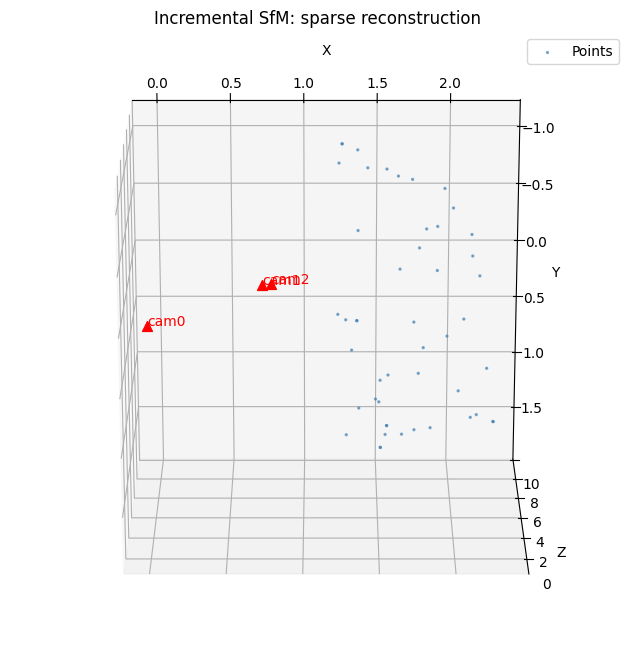

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

if map_points:
    pts = np.array([mp["xyz"] for mp in map_points])
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=2, c="steelblue", alpha=0.6, label="Points")

for idx, pose in enumerate(poses):
    if pose is None:
        continue
    center = -pose["R"].T @ pose["t"]
    # Access scalar values from the 3x1 center array for plotting
    ax.scatter(center[0][0], center[1][0], center[2][0], c="red", marker="^", s=50)
    ax.text(center[0][0], center[1][0], center[2][0], f"cam{idx}", color="red")

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend(loc="best")
ax.view_init(elev=-70, azim=-90)
plt.title("Incremental SfM: sparse reconstruction")
plt.show()
